In [1]:
!pip install underthesea gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)


In [2]:
!pip install tqdm torch

In [4]:
!pip uninstall -y numpy gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3


In [ ]:
!pip install numpy==1.23.5  # Một phiên bản numpy ổn định
!pip install gensim==4.3.2
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from underthesea import word_tokenize
from tqdm import tqdm
import underthesea

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import joblib
import random

# Load data và EDA

In [ ]:
df = pd.read_csv("dataset-feedback.csv")

In [ ]:
df.head(10)

,content,score
0,nó làm cho tui bực bội,1
1,k đăng video đc,2
2,gần đây TiKTok hơi lag,3
3,tuyệt vời,5
4,Rất tốt!!!,5
5,hay nhưng hơi lag với tốn dùng lượng tí,4
6,tôi thật sự thất vọng tôi đang nhắn bth k nhắn...,1
7,cũng tạm thui,4
8,vì hở ra là vi phạm cộng đồng mỗi cái việc tạo...,2
9,Tài khoản tiktok của tôi không đăng cái j vi p...,3


In [ ]:
df.shape

(2385066, 2)

In [ ]:
df.isnull().sum()

,0
content,59
score,0


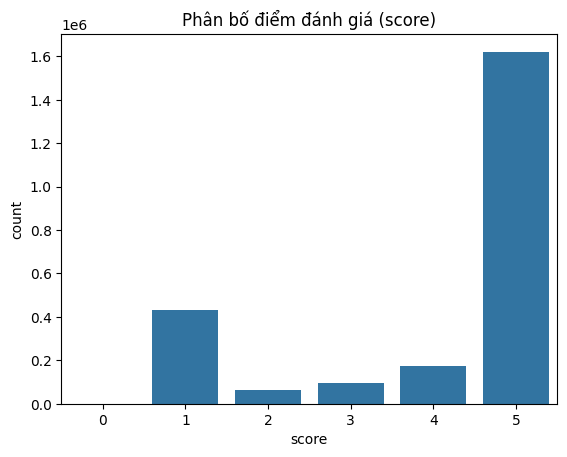

In [ ]:
sns.countplot(data=df, x='score')
plt.title('Phân bố điểm đánh giá (score)')
plt.show()

In [ ]:
# Kiểm tra mẫu trùng lặp
duplicates = df[df.duplicated(subset=['content'], keep=False)].sort_values('content')
print(duplicates.groupby('content').size().value_counts())

# Phân bố trùng lặp theo class
print("Tỷ lệ trùng lặp theo class:")
print(df[df.duplicated(subset=['content'])]['score'].value_counts(normalize=True))

2       55237
3        9738
4        4868
5        2964
6        2078
        ...  
4494        1
2414        1
995         1
511         1
261         1
Name: count, Length: 536, dtype: int64
Tỷ lệ trùng lặp theo class:
score
5    0.832490
1    0.069699
4    0.066222
3    0.022457
2    0.009129
0    0.000003
Name: proportion, dtype: float64


# Data Cleaning

In [ ]:
df_cleaned = df.replace([
    '', ' ', 'NA', 'NaN', 'null',
    'NULL', 'None', 'N/A', 'n/a'
], np.nan)

df_cleaned = df_cleaned.dropna(subset=['content'])

In [ ]:
def handle_duplicates(df_cleaned):
    # Tách riêng class 5
    df_class5 = df[df['score'] == 5]
    other_classes = df[df['score'] != 5]

    # Với class 5 - giữ lại UNIQUE + 10% bản sao ngẫu nhiên (để giữ một phần tín hiệu spam)
    df_class5_dedup = pd.concat([
        df_class5.drop_duplicates(subset=['content']),
        df_class5[df_class5.duplicated(subset=['content'])].sample(frac=0.1, random_state=42)
    ])

    # Với các class khác - giữ nguyên (vì trùng lặp không đáng kể)
    return pd.concat([df_class5_dedup, other_classes])

df_cleaned = handle_duplicates(df_cleaned)

In [ ]:
df_cleaned.shape

(1463548, 2)

In [ ]:
# Load slang dictionary
def load_slang_dict(filepath="slang_words.txt"):
    slang_words = {}
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if " : " in line:
                slang, replacement = line.split(" : ", 1)
                slang_words[slang] = replacement
    return slang_words

slang_dict = load_slang_dict()

In [ ]:
# Ánh xạ emoji
EMOJI_MAP = {
    "😍": "tích_cực", "❤️": "tích_cực", "👍": "tích_cực", "😊": "tích_cực",
    "😡": "tiêu_cực", "👎": "tiêu_cực", "😞": "tiêu_cực", "😠": "tiêu_cực",
    "😐": "trung_lập", "🤔": "trung_lập"
}
# Ánh xạ tiếng Anh
ENGLISH_MAP = {
    "good": "tốt", "bad": "tệ", "nice": "đẹp", "slow": "chậm", "fast": "nhanh",
    "lag": "lag", "error": "lỗi", "great": "tuyệt", "ok": "được", "love": "thích"
}


In [ ]:
# Hàm làm sạch dữ liệu
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()

    text = unicodedata.normalize("NFC", text)
    text = text.lower()
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệ'
                  r'óòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữự'
                  r'ýỳỷỹỵđ_]', ' ', text)

    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' ', text)
    text = re.sub(r'(?<!\d)\d{10,11}(?!\d)', ' ', text)
    text = re.sub(r'[@#]\w+', ' ', text)

    words = text.split()
    text = " ".join([slang_dict.get(word, word) for word in words])

    words = text.split()
    text = " ".join([ENGLISH_MAP.get(word, word) for word in words])

    for emoji, sentiment in EMOJI_MAP.items():
        text = text.replace(emoji, f" {sentiment} ")
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text)

    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Áp dụng
tqdm.pandas(desc="Cleaning dữ liệu")
df_cleaned['content'] = df['content'].progress_apply(clean_text)

# Lưu
df_cleaned.to_csv("cleaned_feedback.csv", index=False, encoding='utf-8-sig')

Cleaning dữ liệu: 100%|██████████| 2385066/2385066 [01:04<00:00, 37207.85it/s]


In [ ]:
df_cleaned  = pd.read_csv("cleaned_feedback.csv")

In [ ]:
df_cleaned.head(10)

,content,score
0,tuyệt vời,5
1,rất tốt,5
2,rất tốt,5
3,hơi lag,5
4,tốt,5
5,tiktok rất bổ ích và tuyệt vời,5
6,rất tuyệt vời,5
7,ổn,5
8,tuyệt,5
9,tuyệt,5


# Gán nhãn cho data
- 0: Tiêu cực
- 1: Trung lập
- 2: Tích cực

In [ ]:
POSITIVE_KEYWORDS = ['tốt', 'hài_lòng', 'nhanh', 'đẹp', 'chất_lượng', 'thích', 'tuyệt', 'đáng_tiền', 'tích_cực', 'cảm_ơn', 'ổn']
NEGATIVE_KEYWORDS = ['tệ', 'kém', 'chậm', 'lỗi', 'đắt', 'thất_vọng', 'hỏng', 'dở', 'tiêu_cực']
NEUTRAL_KEYWORDS = ['cũng', 'tạm', 'bình_thường', 'trung_lập']
NEGATION_WORDS = ['không', 'chẳng', 'chưa']

In [ ]:
# Gán nhãn từ số sao
def label_by_score(score):
    if pd.isna(score):
        return None
    if score <= 2:
        return 0  # Tiêu cực
    elif score == 3:
        return 1  # Trung lập
    else:
        return 2  # Tích cực

In [ ]:
# Gán nhãn từ nội dung
def label_by_content(text):
    if not text or pd.isna(text):
        return None

    pos_count = sum(kw in text for kw in POSITIVE_KEYWORDS)
    neg_count = sum(kw in text for kw in NEGATIVE_KEYWORDS)
    neutral_count = sum(kw in text for kw in NEUTRAL_KEYWORDS)

    for kw in POSITIVE_KEYWORDS:
        if kw in text and any(f"{neg} {kw}" in text for neg in NEGATION_WORDS):
            neg_count += 1
    for kw in NEGATIVE_KEYWORDS:
        if kw in text and any(f"{neg} {kw}" in text for neg in NEGATION_WORDS):
            pos_count += 1

    if neutral_count > 0 and pos_count == neg_count:
        return 1  # Trung lập
    if pos_count > neg_count:
        return 2  # Tích cực
    elif neg_count > pos_count:
        return 0  # Tiêu cực
    else:
        return 1  # Trung lập

In [ ]:
# Xử lý mâu thuẫn
def resolve_conflict(row):
    label_score = row['label_score']
    label_content = row['label_content']
    text = row['content']

    if label_score is None:
        return label_content if label_content is not None else 1  # Trung lập

    if label_score == label_content or label_content is None:
        return label_score

    if label_score == 2 and label_content == 0:  # Sao cao (Tích cực) nhưng nội dung Tiêu cực
        if "nhưng" in text or any(word in text for word in ["rất", "quá", "cực_kỳ"]):
            return 0  # Tiêu cực
        return 0 if sum(kw in text for kw in NEGATIVE_KEYWORDS) > 1 else 2  # Tiêu cực hoặc Tích cực

    if label_score == 0 and label_content == 2:  # Sao thấp (Tiêu cực) nhưng nội dung Tích cực
        if "nhưng" in text or any(word in text for word in ["rất", "quá", "cực_kỳ"]):
            return 2  # Tích cực
        return 2 if sum(kw in text for kw in POSITIVE_KEYWORDS) > 1 else 0  # Tích cực hoặc Tiêu cực

    if label_score == 1:  # Sao trung lập
        return label_content

    return label_content if label_content is not None else label_score

In [ ]:
# Áp dụng gán nhãn
tqdm.pandas(desc="Gán nhãn từ số sao")
df_cleaned['label_score'] = df_cleaned['score'].progress_apply(label_by_score)

tqdm.pandas(desc="Gán nhãn từ nội dung")
df_cleaned['label_content'] = df_cleaned['content'].progress_apply(label_by_content)

tqdm.pandas(desc="Xử lý mâu thuẫn")
df_cleaned['final_label'] = df_cleaned.progress_apply(resolve_conflict, axis=1)

Xử lý mâu thuẫn: 100%|██████████| 1463548/1463548 [00:15<00:00, 96257.41it/s] 


In [ ]:
# Thống kê
print("\nPhân bố nhãn cuối cùng:")
print(df_cleaned['final_label'].value_counts())


Phân bố nhãn cuối cùng:
final_label
1.0    999920
2.0    343755
0.0    100503
Name: count, dtype: int64


In [ ]:
df_cleaned.head(10)

,content,score,label_score,label_content,final_label
0,tuyệt vời,5,2,2.0,2.0
1,rất tốt,5,2,2.0,2.0
2,rất tốt,5,2,2.0,2.0
3,hơi lag,5,2,1.0,1.0
4,tốt,5,2,2.0,2.0
5,tiktok rất bổ ích và tuyệt vời,5,2,2.0,2.0
6,rất tuyệt vời,5,2,2.0,2.0
7,ổn,5,2,2.0,2.0
8,tuyệt,5,2,2.0,2.0
9,tuyệt,5,2,2.0,2.0


In [ ]:
# Cân bằng dữ liệu
df_positive = df_cleaned[df_cleaned['final_label'] == 2]  # Tích cực
df_negative = df_cleaned[df_cleaned['final_label'] == 0]  # Tiêu cực
df_neutral = df_cleaned[df_cleaned['final_label'] == 1]   # Trung lập

# Sử dụng target_size dựa trên nhãn Tích cực
target_size_positive = len(df_positive)  # 343,755 mẫu
target_size_negative = target_size_positive // 2  # 171,878 mẫu
target_size_neutral = target_size_positive * 3 // 2  # 515,633 mẫu

df_negative_up = df_negative.sample(n=target_size_negative, replace=True, random_state=42)
df_neutral_down = df_neutral.sample(n=target_size_neutral, random_state=42)
df_positive = df_positive  # Giữ nguyên

df_balanced = pd.concat([df_positive, df_negative_up, df_neutral_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nPhân bố nhãn sau cân bằng (tỷ lệ 1:3:2):")
print(df_balanced['final_label'].value_counts())


Phân bố nhãn sau cân bằng (tỷ lệ 1:3:2):
final_label
1.0    515632
2.0    343755
0.0    171877
Name: count, dtype: int64


In [ ]:
# Tính class weights dựa trên phân bố ban đầu
class_counts = df_cleaned['final_label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {0: total_samples / (3 * class_counts[0]),
                 1: total_samples / (3 * class_counts[1]),
                 2: total_samples / (3 * class_counts[2])}
print("\nClass weights:")
print(class_weights)


Class weights:
{0: 4.78983380263939, 1: 0.48143118116115957, 2: 1.4003946609261442}


In [ ]:
df_balanced.to_csv("balanced_labeled_feedback.csv", index=False, encoding='utf-8-sig')

# Tiền xử lý trước khi vector hóa

In [ ]:
# Load stopwords
def load_stopwords(filepath="stopword.txt"):
    with open(filepath, "r", encoding="utf-8") as f:
        return set(f.read().split())

stopwords = load_stopwords()

# Hàm tiền xử lý
def preprocess_for_vectorization(text):
    try:
        tokens = word_tokenize(text)
        text = " ".join([token.replace(" ", "_") if " " in token else token for token in tokens])
    except:
        pass

    words = text.split()
    text = " ".join([word for word in words if word not in stopwords])
    return text

# Áp dụng
tqdm.pandas(desc="Tiền xử lý cho vector hóa")
df_balanced['content_processed'] = df_balanced['content'].progress_apply(preprocess_for_vectorization)

Tiền xử lý cho vector hóa: 100%|██████████| 1031264/1031264 [12:48<00:00, 1341.28it/s]


In [ ]:
# Lưu
df_balanced.to_csv("processed_feedback.csv", index=False, encoding='utf-8-sig')

# Vector hóa bằng BoW, BoW + n-grams, TF - IDF, TF - IDF + n - grams

In [ ]:
# BoW
bow = CountVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_bow = bow.fit_transform(df_balanced['content_processed'])

# BoW + N-gram
bow_ngram = CountVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)
X_bow_ngram = bow_ngram.fit_transform(df_balanced['content_processed'])

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(df_balanced['content_processed'])

# TF-IDF + N-gram
tfidf_ngram = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)
X_tfidf_ngram = tfidf_ngram.fit_transform(df_balanced['content_processed'])

# Huấn luyện và đánh giá mô hình học máy (NB, LR, DT)

In [ ]:
def evaluate_model(model, X, y, name, representation):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {name} ({representation}) ===")
    print(classification_report(y_test, y_pred, target_names=['Tiêu cực (0)', 'Trung lập (1)', 'Tích cực (2)']))

    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Tiêu cực (0)', 'Trung lập (1)', 'Tích cực (2)'],
                yticklabels=['Tiêu cực (0)', 'Trung lập (1)', 'Tích cực (2)'])
    plt.title(f'Confusion Matrix - {name} ({representation})')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

    return model, f1

In [ ]:
# Khởi tạo mô hình với class weights
nb = MultinomialNB(alpha=0.1)  # Naive Bayes không hỗ trợ class weights trực tiếp
lr = LogisticRegression(C=1.0, solver='saga', class_weight=class_weights, max_iter=1000)
dt = DecisionTreeClassifier(max_depth=10, class_weight=class_weights)

In [ ]:
representations = {
    'BoW': X_bow,
    'BoW + N-gram': X_bow_ngram,
    'TF-IDF': X_tfidf,
    'TF-IDF + N-gram': X_tfidf_ngram
}


=== Naive Bayes (BoW) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.71      0.79      0.75     34375
Trung lập (1)       0.94      0.84      0.89    103127
 Tích cực (2)       0.83      0.92      0.88     68751

     accuracy                           0.86    206253
    macro avg       0.83      0.85      0.84    206253
 weighted avg       0.87      0.86      0.86    206253

Macro F1: 0.8357


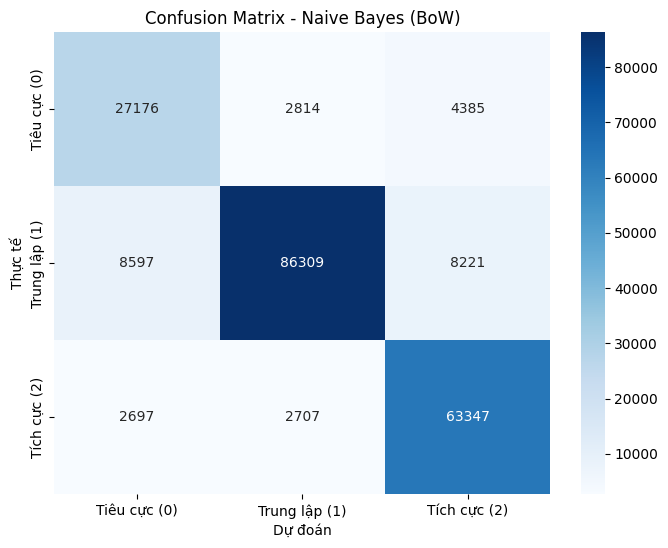

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Logistic Regression (BoW) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.85      0.86      0.86     34375
Trung lập (1)       0.98      0.97      0.97    103127
 Tích cực (2)       0.93      0.94      0.93     68751

     accuracy                           0.94    206253
    macro avg       0.92      0.92      0.92    206253
 weighted avg       0.94      0.94      0.94    206253

Macro F1: 0.9211


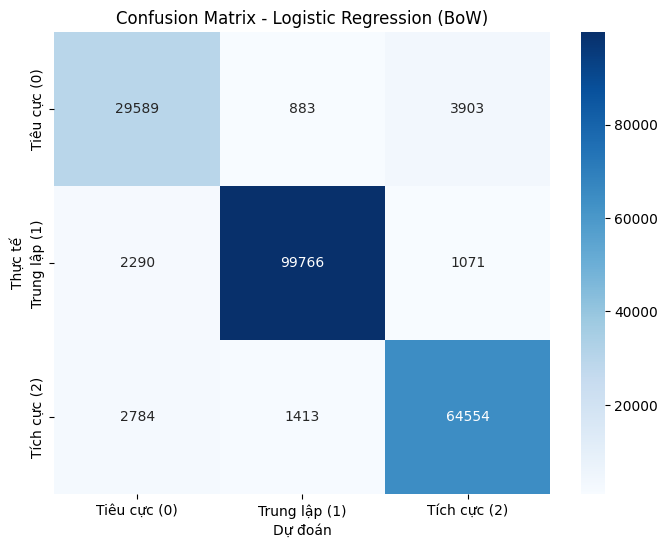


=== Decision Tree (BoW) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.92      0.73      0.81     34375
Trung lập (1)       0.88      0.99      0.93    103127
 Tích cực (2)       0.92      0.85      0.88     68751

     accuracy                           0.90    206253
    macro avg       0.90      0.85      0.87    206253
 weighted avg       0.90      0.90      0.89    206253

Macro F1: 0.8746


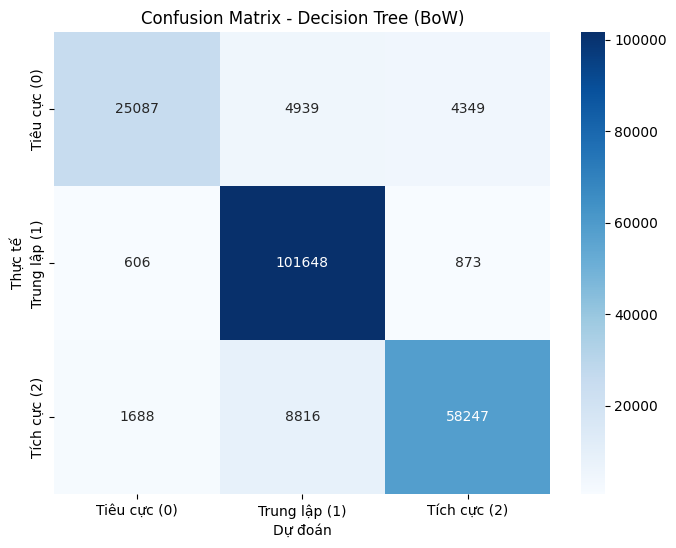


=== Naive Bayes (BoW + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.70      0.79      0.74     34375
Trung lập (1)       0.94      0.84      0.89    103127
 Tích cực (2)       0.85      0.92      0.88     68751

     accuracy                           0.86    206253
    macro avg       0.83      0.85      0.84    206253
 weighted avg       0.87      0.86      0.86    206253

Macro F1: 0.8375


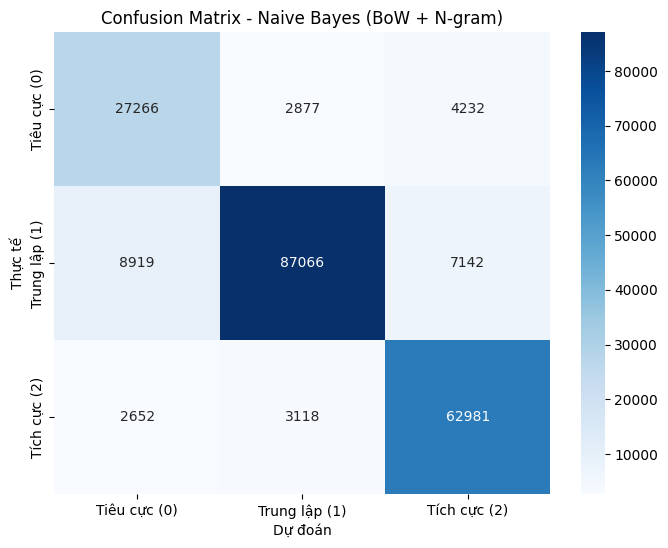

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Logistic Regression (BoW + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.83      0.86      0.85     34375
Trung lập (1)       0.97      0.96      0.96    103127
 Tích cực (2)       0.93      0.93      0.93     68751

     accuracy                           0.93    206253
    macro avg       0.91      0.92      0.91    206253
 weighted avg       0.93      0.93      0.93    206253

Macro F1: 0.9131


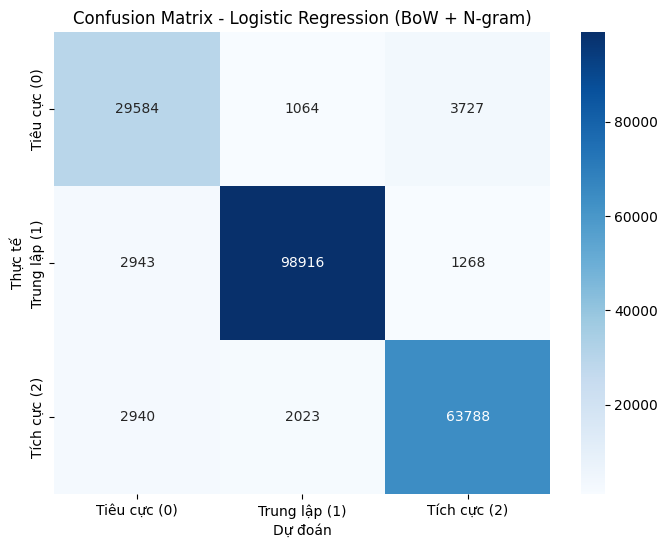


=== Decision Tree (BoW + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.91      0.73      0.81     34375
Trung lập (1)       0.88      0.99      0.93    103127
 Tích cực (2)       0.92      0.85      0.88     68751

     accuracy                           0.90    206253
    macro avg       0.90      0.85      0.87    206253
 weighted avg       0.90      0.90      0.89    206253

Macro F1: 0.8744


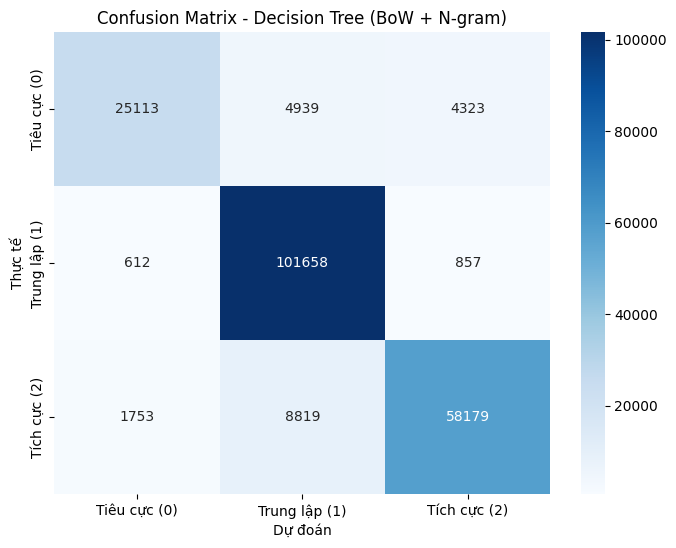


=== Naive Bayes (TF-IDF) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.80      0.69      0.74     34375
Trung lập (1)       0.86      0.92      0.89    103127
 Tích cực (2)       0.87      0.85      0.86     68751

     accuracy                           0.86    206253
    macro avg       0.84      0.82      0.83    206253
 weighted avg       0.85      0.86      0.85    206253

Macro F1: 0.8291


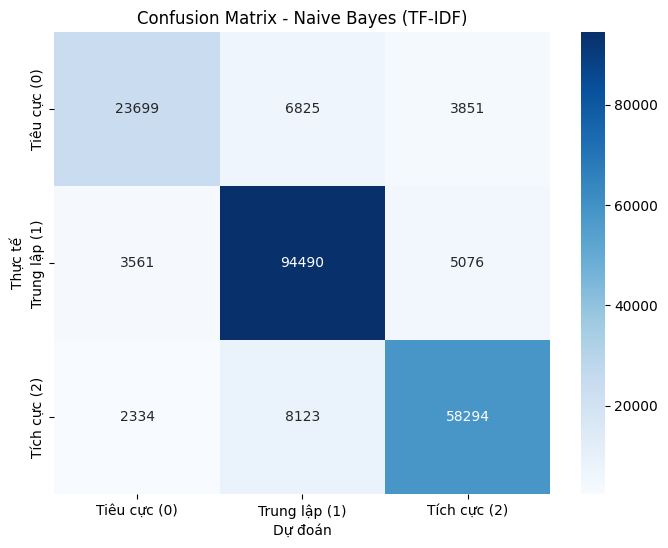

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Logistic Regression (TF-IDF) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.74      0.87      0.80     34375
Trung lập (1)       0.98      0.95      0.96    103127
 Tích cực (2)       0.93      0.89      0.91     68751

     accuracy                           0.92    206253
    macro avg       0.88      0.90      0.89    206253
 weighted avg       0.92      0.92      0.92    206253

Macro F1: 0.8919


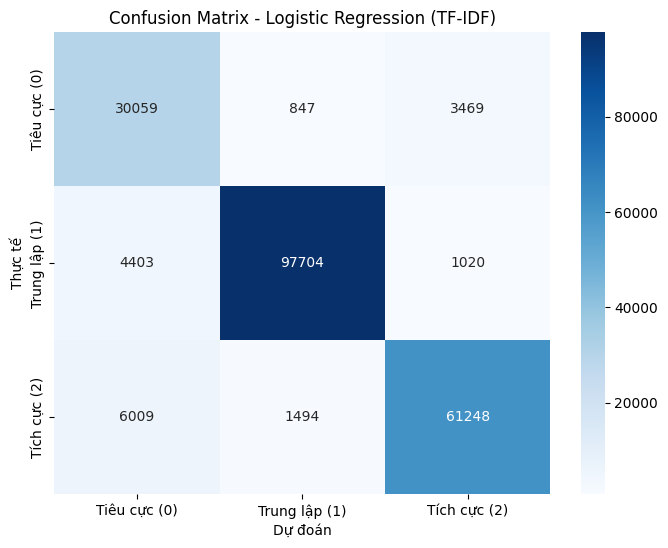


=== Decision Tree (TF-IDF) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.90      0.73      0.81     34375
Trung lập (1)       0.88      0.99      0.93    103127
 Tích cực (2)       0.92      0.83      0.87     68751

     accuracy                           0.89    206253
    macro avg       0.90      0.85      0.87    206253
 weighted avg       0.89      0.89      0.89    206253

Macro F1: 0.8701


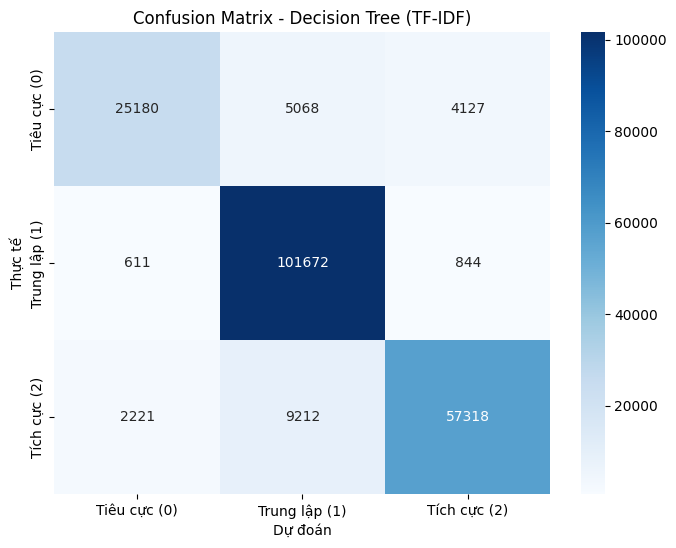


=== Naive Bayes (TF-IDF + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.80      0.73      0.76     34375
Trung lập (1)       0.89      0.92      0.90    103127
 Tích cực (2)       0.88      0.87      0.88     68751

     accuracy                           0.87    206253
    macro avg       0.86      0.84      0.85    206253
 weighted avg       0.87      0.87      0.87    206253

Macro F1: 0.8477


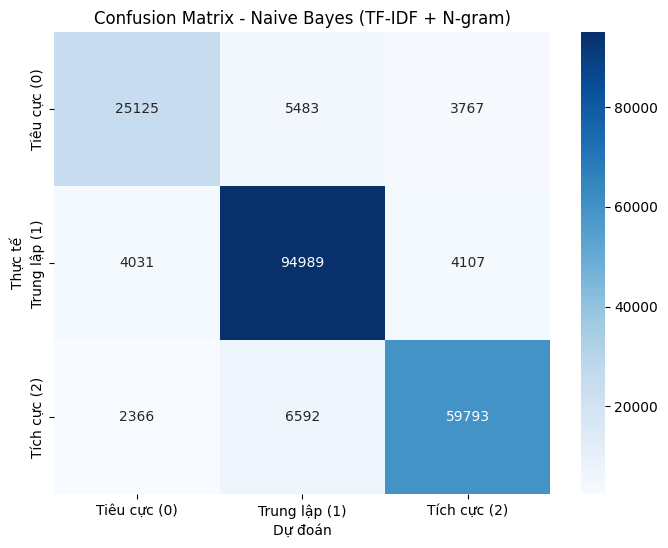

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Logistic Regression (TF-IDF + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.80      0.86      0.83     34375
Trung lập (1)       0.97      0.95      0.96    103127
 Tích cực (2)       0.92      0.91      0.92     68751

     accuracy                           0.92    206253
    macro avg       0.90      0.91      0.90    206253
 weighted avg       0.93      0.92      0.93    206253

Macro F1: 0.9030


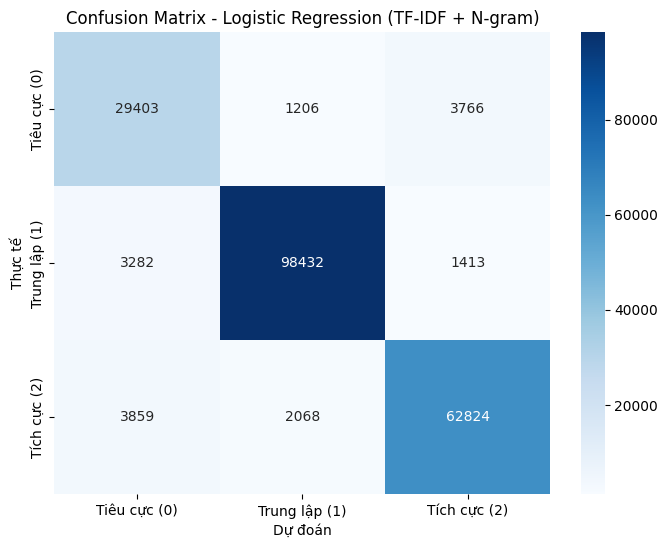


=== Decision Tree (TF-IDF + N-gram) ===
               precision    recall  f1-score   support

 Tiêu cực (0)       0.90      0.73      0.81     34375
Trung lập (1)       0.88      0.99      0.93    103127
 Tích cực (2)       0.92      0.84      0.88     68751

     accuracy                           0.89    206253
    macro avg       0.90      0.85      0.87    206253
 weighted avg       0.90      0.89      0.89    206253

Macro F1: 0.8710


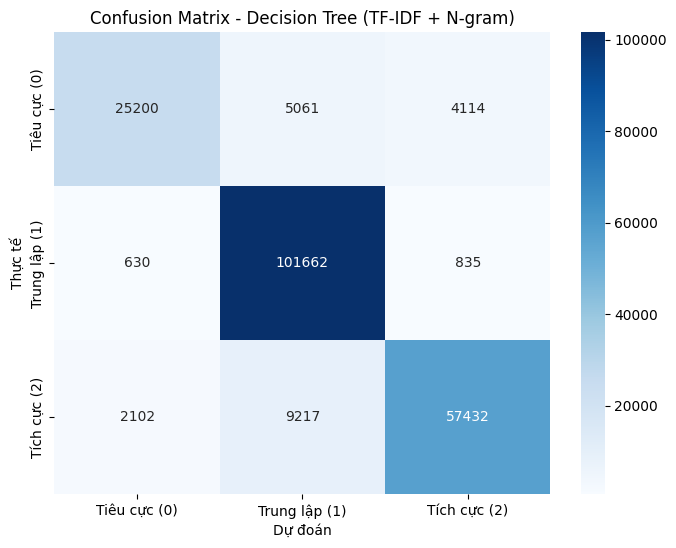

In [ ]:
models = {'Naive Bayes': nb, 'Logistic Regression': lr, 'Decision Tree': dt}
results = []
trained_models = {}

for rep_name, X in representations.items():
    for model_name, model in models.items():
        trained_model, f1 = evaluate_model(model, X, df_balanced['final_label'], model_name, rep_name)
        results.append({'Representation': rep_name, 'Model': model_name, 'Macro F1': f1})
        if rep_name == 'TF-IDF' and model_name == 'Decision Tree':
            trained_models['DecisionTree_TFIDF'] = trained_model

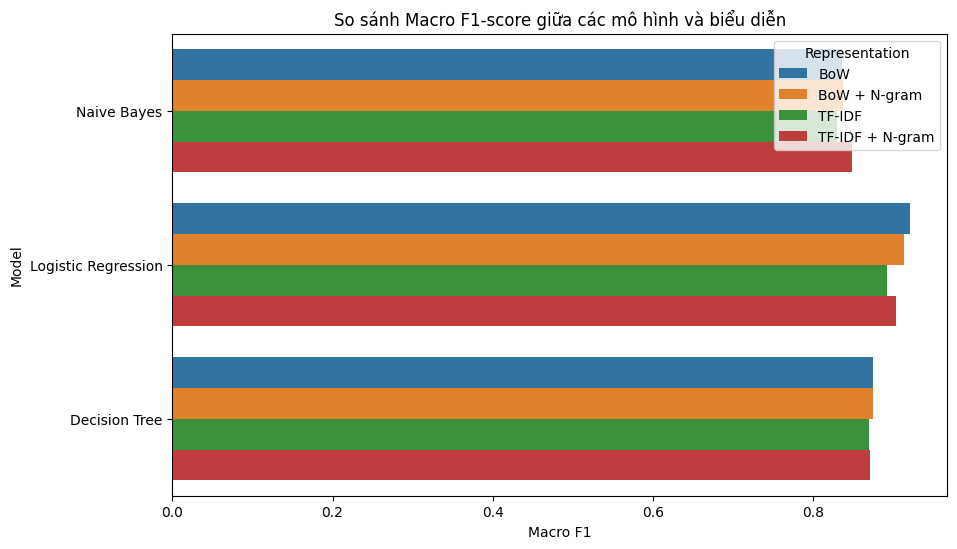

In [ ]:
# Vẽ biểu đồ so sánh
results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
sns.barplot(x='Macro F1', y='Model', hue='Representation', data=results_df)
plt.title('So sánh Macro F1-score giữa các mô hình và biểu diễn')
plt.show()

In [ ]:
test_cases = [
    "Dịch vụ giao hàng rất nhanh và tiện lợi!",
    "Chất lượng sản phẩm tệ, tôi rất thất vọng.",
    "Ứng dụng này dễ sử dụng và giao diện thân thiện.",
    "Rất hài lòng với chất lượng sản phẩm, sẽ mua lại lần sau!",
    "cũng cũng",
    "không mua lại",
    "nói chung là tệ"
]
def preprocess_test_case(text):
    text = clean_text(text)
    text = preprocess_for_vectorization(text)
    return text

test_processed = [preprocess_test_case(text) for text in test_cases]
X_test = tfidf.transform(test_processed)
y_pred = trained_models['DecisionTree_TFIDF'].predict(X_test)

# In kết quả
print("\n=== Dự đoán trên test case (TF-IDF + Decision Tree) ===")
label_map = {0: 'Tiêu cực', 1: 'Trung lập', 2: 'Tích cực'}
for text, label in zip(test_cases, y_pred):
    print(f"Câu: '{text}' -> Dự đoán: {label} ({label_map[label]})")


=== Dự đoán trên test case (TF-IDF + Decision Tree) ===
Câu: 'Dịch vụ giao hàng rất nhanh và tiện lợi!' -> Dự đoán: 1.0 (Trung lập)
Câu: 'Chất lượng sản phẩm tệ, tôi rất thất vọng.' -> Dự đoán: 1.0 (Trung lập)
Câu: 'Ứng dụng này dễ sử dụng và giao diện thân thiện.' -> Dự đoán: 1.0 (Trung lập)
Câu: 'Rất hài lòng với chất lượng sản phẩm, sẽ mua lại lần sau!' -> Dự đoán: 1.0 (Trung lập)
Câu: 'cũng cũng' -> Dự đoán: 1.0 (Trung lập)
Câu: 'không mua lại' -> Dự đoán: 1.0 (Trung lập)
Câu: 'nói chung là tệ' -> Dự đoán: 1.0 (Trung lập)


# Biểu diễn dạng vector bằng Doc2Vec và huấn luyện mô hình Doc2Vec

In [4]:
df_processed = pd.read_csv("processed_feedback.csv", encoding='utf-8-sig')

In [5]:
# Drop các cột không cần thiết
columns_to_keep = ['content_processed', 'final_label']
df_processed = df_processed[columns_to_keep]

In [6]:
df_processed['content_processed'] = df_processed['content_processed'].astype(str)

In [7]:
# Chuẩn bị dữ liệu cho Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[str(i)])
             for i, text in enumerate(df_processed['content_processed'])]

In [8]:
for doc in documents[:3]:
    print(doc)

TaggedDocument<['miễn_phí', 'vận_chuyển', 'chương_trình', 'khuyến_mãi'], ['0']>
TaggedDocument<['shopee', 'sai', 'bắt', 'người', 'dùnh', 'truy_thu', 'làm_ăn', 'lol'], ['1']>
TaggedDocument<['người', 'hâm_mộ', 'tôi'], ['2']>


In [9]:
doc2vec = Doc2Vec(documents, vector_size=100, window=5, min_count=3, epochs=20, dm=1, workers=4)
doc2vec.save("doc2vec_model")

In [10]:
# Vector hóa
X_doc2vec = [doc2vec.infer_vector(text.split()) for text in tqdm(df_processed['content_processed'], desc="Vector hóa bằng Doc2Vec")]
X_doc2vec = np.array(X_doc2vec)

Vector hóa bằng Doc2Vec: 100%|██████████| 1031264/1031264 [13:18<00:00, 1290.80it/s]


In [11]:
# Lưu vector X_doc2vec để tái sử dụng
np.save("X_doc2vec.npy", X_doc2vec)
print("Đã lưu vector X_doc2vec vào file X_doc2vec.npy")

Đã lưu vector X_doc2vec vào file X_doc2vec.npy


In [ ]:
# # Load mô hình Doc2Vec đã lưu
# doc2vec = Doc2Vec.load("doc2vec_model")
# print("Đã load mô hình Doc2Vec")

# # Load vector X_doc2vec đã lưu
# X_doc2vec = np.load("X_doc2vec.npy")
# print("Đã load vector X_doc2vec")

# Huấn luyện và đánh giá mô hình học sâu (CNN, LSTM)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang sử dụng: {device}")

Thiết bị đang sử dụng: cuda


In [25]:
# Chuẩn bị dữ liệu
X_doc2vec_tensor = torch.tensor(X_doc2vec, dtype=torch.float32).to(device)
y_tensor = torch.tensor(df_processed['final_label'].values, dtype=torch.long).to(device)
dataset = TensorDataset(X_doc2vec_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, pin_memory=False)

In [34]:
# Tính lại class weights (dựa trên df_processed)
class_counts = df_processed['final_label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {0: total_samples / (3 * class_counts[0]),
                 1: total_samples / (3 * class_counts[1]),
                 2: total_samples / (3 * class_counts[2])}
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]], dtype=torch.float).to(device)

In [15]:
# Định nghĩa mô hình (giữ nguyên)
class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(256 * (input_size // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.embedding(x))
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        attn_weights = torch.softmax(self.attention(out), dim=1)
        out = torch.sum(out * attn_weights, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [35]:
# Focal Loss với class weights
class FocalLossWithClassWeights(nn.Module):
    def __init__(self, alpha=1, gamma=2, class_weights=None):
        super(FocalLossWithClassWeights, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        CE_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.class_weights)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss
        return F_loss.mean()

In [36]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs=15, learning_rate=2e-3, patience=5):
    model = model.to(device)
    criterion = FocalLossWithClassWeights(alpha=1, gamma=2, class_weights=class_weights_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    best_f1 = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Chế độ huấn luyện (Dropout bật)
        train_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.eval()  # Chế độ đánh giá (Dropout tắt)
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(all_labels, all_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}')
        print(classification_report(val_labels, val_preds, target_names=['Tiêu cực (0)', 'Trung lập (1)', 'Tích cực (2)']))

        scheduler.step(val_loss)
        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping tại Epoch {epoch+1}. Best Val F1: {best_f1:.4f}")
                break

In [32]:
cnn = CNNClassifier(input_size=100, num_classes=3)
lstm = LSTMClassifier(input_size=100, hidden_size=128, num_layers=2, num_classes=3)

In [37]:
train_and_evaluate(cnn, train_loader, val_loader, num_epochs=15, learning_rate=1e-3, patience=5)

Epoch 1/15 [Train]: 100%|██████████| 12891/12891 [00:57<00:00, 222.81it/s]


Epoch 1: Train Loss: 0.3097, Train F1: 0.6356
Val Loss: 0.2670, Val F1: 0.6965
               precision    recall  f1-score   support

 Tiêu cực (0)       0.50      0.78      0.61     34423
Trung lập (1)       0.88      0.59      0.71    102961
 Tích cực (2)       0.70      0.86      0.77     68869

     accuracy                           0.71    206253
    macro avg       0.69      0.74      0.70    206253
 weighted avg       0.76      0.71      0.71    206253



Epoch 2/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 251.21it/s]


Epoch 2: Train Loss: 0.3014, Train F1: 0.6484
Val Loss: 0.2715, Val F1: 0.6761
               precision    recall  f1-score   support

 Tiêu cực (0)       0.52      0.76      0.62     34423
Trung lập (1)       0.89      0.52      0.66    102961
 Tích cực (2)       0.64      0.90      0.75     68869

     accuracy                           0.69    206253
    macro avg       0.69      0.73      0.68    206253
 weighted avg       0.75      0.69      0.68    206253



Epoch 3/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 252.08it/s]


Epoch 3: Train Loss: 0.2981, Train F1: 0.6534
Val Loss: 0.2640, Val F1: 0.6786
               precision    recall  f1-score   support

 Tiêu cực (0)       0.44      0.81      0.57     34423
Trung lập (1)       0.87      0.56      0.68    102961
 Tích cực (2)       0.74      0.83      0.78     68869

     accuracy                           0.69    206253
    macro avg       0.68      0.73      0.68    206253
 weighted avg       0.76      0.69      0.70    206253



Epoch 4/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 248.76it/s]


Epoch 4: Train Loss: 0.2975, Train F1: 0.6539
Val Loss: 0.2620, Val F1: 0.7087
               precision    recall  f1-score   support

 Tiêu cực (0)       0.53      0.76      0.62     34423
Trung lập (1)       0.88      0.62      0.72    102961
 Tích cực (2)       0.71      0.86      0.78     68869

     accuracy                           0.72    206253
    macro avg       0.70      0.75      0.71    206253
 weighted avg       0.76      0.72      0.73    206253



Epoch 5/15 [Train]: 100%|██████████| 12891/12891 [00:50<00:00, 254.15it/s]


Epoch 5: Train Loss: 0.2957, Train F1: 0.6553
Val Loss: 0.2623, Val F1: 0.7173
               precision    recall  f1-score   support

 Tiêu cực (0)       0.53      0.75      0.62     34423
Trung lập (1)       0.86      0.66      0.74    102961
 Tích cực (2)       0.74      0.84      0.79     68869

     accuracy                           0.73    206253
    macro avg       0.71      0.75      0.72    206253
 weighted avg       0.76      0.73      0.74    206253



Epoch 6/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 250.81it/s]


Epoch 6: Train Loss: 0.2954, Train F1: 0.6572
Val Loss: 0.2620, Val F1: 0.6835
               precision    recall  f1-score   support

 Tiêu cực (0)       0.49      0.78      0.60     34423
Trung lập (1)       0.89      0.55      0.68    102961
 Tích cực (2)       0.69      0.87      0.77     68869

     accuracy                           0.70    206253
    macro avg       0.69      0.73      0.68    206253
 weighted avg       0.76      0.70      0.70    206253



Epoch 7/15 [Train]: 100%|██████████| 12891/12891 [00:50<00:00, 252.96it/s]


Epoch 7: Train Loss: 0.2945, Train F1: 0.6575
Val Loss: 0.2616, Val F1: 0.7043
               precision    recall  f1-score   support

 Tiêu cực (0)       0.54      0.76      0.63     34423
Trung lập (1)       0.89      0.60      0.71    102961
 Tích cực (2)       0.68      0.88      0.77     68869

     accuracy                           0.72    206253
    macro avg       0.70      0.74      0.70    206253
 weighted avg       0.76      0.72      0.72    206253



Epoch 8/15 [Train]: 100%|██████████| 12891/12891 [00:50<00:00, 253.45it/s]


Epoch 8: Train Loss: 0.2946, Train F1: 0.6563
Val Loss: 0.2593, Val F1: 0.6725
               precision    recall  f1-score   support

 Tiêu cực (0)       0.45      0.81      0.58     34423
Trung lập (1)       0.89      0.53      0.66    102961
 Tích cực (2)       0.71      0.86      0.78     68869

     accuracy                           0.69    206253
    macro avg       0.68      0.73      0.67    206253
 weighted avg       0.76      0.69      0.69    206253



Epoch 9/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 252.28it/s]


Epoch 9: Train Loss: 0.2941, Train F1: 0.6587
Val Loss: 0.2659, Val F1: 0.6774
               precision    recall  f1-score   support

 Tiêu cực (0)       0.53      0.76      0.62     34423
Trung lập (1)       0.89      0.52      0.66    102961
 Tích cực (2)       0.64      0.90      0.75     68869

     accuracy                           0.69    206253
    macro avg       0.69      0.73      0.68    206253
 weighted avg       0.75      0.69      0.68    206253



Epoch 10/15 [Train]: 100%|██████████| 12891/12891 [00:51<00:00, 251.45it/s]


Epoch 10: Train Loss: 0.2934, Train F1: 0.6595
Val Loss: 0.2679, Val F1: 0.6960
               precision    recall  f1-score   support

 Tiêu cực (0)       0.57      0.73      0.64     34423
Trung lập (1)       0.88      0.57      0.69    102961
 Tích cực (2)       0.65      0.90      0.75     68869

     accuracy                           0.71    206253
    macro avg       0.70      0.73      0.70    206253
 weighted avg       0.75      0.71      0.70    206253

Early stopping tại Epoch 10. Best Val F1: 0.7173


In [38]:
train_and_evaluate(lstm, train_loader, val_loader, num_epochs=15, learning_rate=1e-3, patience=5)

Epoch 1/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.52it/s]


Epoch 1: Train Loss: 0.2348, Train F1: 0.7109
Val Loss: 0.2128, Val F1: 0.7273
               precision    recall  f1-score   support

 Tiêu cực (0)       0.50      0.82      0.62     34423
Trung lập (1)       0.91      0.63      0.75    102961
 Tích cực (2)       0.76      0.87      0.81     68869

     accuracy                           0.74    206253
    macro avg       0.73      0.77      0.73    206253
 weighted avg       0.79      0.74      0.75    206253



Epoch 2/15 [Train]: 100%|██████████| 12891/12891 [01:09<00:00, 185.75it/s]


Epoch 2: Train Loss: 0.2093, Train F1: 0.7438
Val Loss: 0.2045, Val F1: 0.7403
               precision    recall  f1-score   support

 Tiêu cực (0)       0.51      0.83      0.63     34423
Trung lập (1)       0.92      0.66      0.77    102961
 Tích cực (2)       0.78      0.87      0.82     68869

     accuracy                           0.76    206253
    macro avg       0.74      0.79      0.74    206253
 weighted avg       0.80      0.76      0.76    206253



Epoch 3/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.41it/s]


Epoch 3: Train Loss: 0.2013, Train F1: 0.7519
Val Loss: 0.1977, Val F1: 0.7496
               precision    recall  f1-score   support

 Tiêu cực (0)       0.51      0.84      0.63     34423
Trung lập (1)       0.91      0.69      0.79    102961
 Tích cực (2)       0.82      0.84      0.83     68869

     accuracy                           0.77    206253
    macro avg       0.75      0.79      0.75    206253
 weighted avg       0.81      0.77      0.78    206253



Epoch 4/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 188.68it/s]


Epoch 4: Train Loss: 0.1954, Train F1: 0.7582
Val Loss: 0.1952, Val F1: 0.7573
               precision    recall  f1-score   support

 Tiêu cực (0)       0.54      0.83      0.65     34423
Trung lập (1)       0.91      0.70      0.79    102961
 Tích cực (2)       0.79      0.86      0.83     68869

     accuracy                           0.77    206253
    macro avg       0.75      0.80      0.76    206253
 weighted avg       0.81      0.77      0.78    206253



Epoch 5/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.39it/s]


Epoch 5: Train Loss: 0.1909, Train F1: 0.7626
Val Loss: 0.1916, Val F1: 0.7737
               precision    recall  f1-score   support

 Tiêu cực (0)       0.56      0.83      0.67     34423
Trung lập (1)       0.91      0.74      0.81    102961
 Tích cực (2)       0.82      0.85      0.84     68869

     accuracy                           0.79    206253
    macro avg       0.76      0.81      0.77    206253
 weighted avg       0.82      0.79      0.80    206253



Epoch 6/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.66it/s]


Epoch 6: Train Loss: 0.1868, Train F1: 0.7665
Val Loss: 0.1904, Val F1: 0.7543
               precision    recall  f1-score   support

 Tiêu cực (0)       0.53      0.84      0.65     34423
Trung lập (1)       0.93      0.68      0.78    102961
 Tích cực (2)       0.79      0.87      0.83     68869

     accuracy                           0.77    206253
    macro avg       0.75      0.80      0.75    206253
 weighted avg       0.81      0.77      0.78    206253



Epoch 7/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 189.54it/s]


Epoch 7: Train Loss: 0.1831, Train F1: 0.7700
Val Loss: 0.1910, Val F1: 0.7480
               precision    recall  f1-score   support

 Tiêu cực (0)       0.51      0.86      0.64     34423
Trung lập (1)       0.92      0.67      0.78    102961
 Tích cực (2)       0.81      0.85      0.83     68869

     accuracy                           0.76    206253
    macro avg       0.74      0.79      0.75    206253
 weighted avg       0.81      0.76      0.77    206253



Epoch 8/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 188.22it/s]


Epoch 8: Train Loss: 0.1799, Train F1: 0.7730
Val Loss: 0.1887, Val F1: 0.7611
               precision    recall  f1-score   support

 Tiêu cực (0)       0.55      0.84      0.66     34423
Trung lập (1)       0.92      0.69      0.79    102961
 Tích cực (2)       0.79      0.87      0.83     68869

     accuracy                           0.78    206253
    macro avg       0.75      0.80      0.76    206253
 weighted avg       0.82      0.78      0.78    206253



Epoch 9/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.23it/s]


Epoch 9: Train Loss: 0.1770, Train F1: 0.7763
Val Loss: 0.1881, Val F1: 0.7807
               precision    recall  f1-score   support

 Tiêu cực (0)       0.58      0.83      0.68     34423
Trung lập (1)       0.91      0.75      0.82    102961
 Tích cực (2)       0.83      0.85      0.84     68869

     accuracy                           0.80    206253
    macro avg       0.77      0.81      0.78    206253
 weighted avg       0.82      0.80      0.80    206253



Epoch 10/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 188.31it/s]


Epoch 10: Train Loss: 0.1740, Train F1: 0.7788
Val Loss: 0.1867, Val F1: 0.7766
               precision    recall  f1-score   support

 Tiêu cực (0)       0.56      0.84      0.67     34423
Trung lập (1)       0.91      0.75      0.82    102961
 Tích cực (2)       0.83      0.84      0.84     68869

     accuracy                           0.79    206253
    macro avg       0.77      0.81      0.78    206253
 weighted avg       0.82      0.79      0.80    206253



Epoch 11/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 189.52it/s]


Epoch 11: Train Loss: 0.1715, Train F1: 0.7810
Val Loss: 0.1892, Val F1: 0.7915
               precision    recall  f1-score   support

 Tiêu cực (0)       0.62      0.82      0.70     34423
Trung lập (1)       0.91      0.77      0.83    102961
 Tích cực (2)       0.81      0.87      0.84     68869

     accuracy                           0.81    206253
    macro avg       0.78      0.82      0.79    206253
 weighted avg       0.83      0.81      0.81    206253



Epoch 12/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 186.83it/s]


Epoch 12: Train Loss: 0.1693, Train F1: 0.7832
Val Loss: 0.1902, Val F1: 0.7899
               precision    recall  f1-score   support

 Tiêu cực (0)       0.60      0.82      0.69     34423
Trung lập (1)       0.90      0.78      0.84    102961
 Tích cực (2)       0.84      0.85      0.84     68869

     accuracy                           0.81    206253
    macro avg       0.78      0.82      0.79    206253
 weighted avg       0.83      0.81      0.81    206253



Epoch 13/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 187.26it/s]


Epoch 13: Train Loss: 0.1671, Train F1: 0.7854
Val Loss: 0.1861, Val F1: 0.7728
               precision    recall  f1-score   support

 Tiêu cực (0)       0.56      0.84      0.68     34423
Trung lập (1)       0.92      0.72      0.81    102961
 Tích cực (2)       0.80      0.87      0.84     68869

     accuracy                           0.79    206253
    macro avg       0.76      0.81      0.77    206253
 weighted avg       0.82      0.79      0.79    206253



Epoch 14/15 [Train]: 100%|██████████| 12891/12891 [01:08<00:00, 188.85it/s]


Epoch 14: Train Loss: 0.1653, Train F1: 0.7874
Val Loss: 0.1872, Val F1: 0.7700
               precision    recall  f1-score   support

 Tiêu cực (0)       0.56      0.84      0.67     34423
Trung lập (1)       0.92      0.72      0.80    102961
 Tích cực (2)       0.81      0.87      0.84     68869

     accuracy                           0.79    206253
    macro avg       0.76      0.81      0.77    206253
 weighted avg       0.82      0.79      0.79    206253



Epoch 15/15 [Train]: 100%|██████████| 12891/12891 [01:09<00:00, 185.83it/s]


Epoch 15: Train Loss: 0.1634, Train F1: 0.7889
Val Loss: 0.1882, Val F1: 0.7766
               precision    recall  f1-score   support

 Tiêu cực (0)       0.57      0.84      0.68     34423
Trung lập (1)       0.91      0.74      0.82    102961
 Tích cực (2)       0.81      0.86      0.84     68869

     accuracy                           0.79    206253
    macro avg       0.77      0.81      0.78    206253
 weighted avg       0.82      0.79      0.80    206253



In [42]:
import re

# Định nghĩa hàm tiền xử lý
def preprocess_for_vectorization(text):
    # Chuyển thành chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Định nghĩa lại hàm clean_text (nếu chưa có)
def clean_text(text):
    # Chuyển thành chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Sửa đoạn code dự đoán
test_cases = [
    "Ứng dụng rất hay và tiện lợi",  # Tích cực
    "Tôi không hài lòng chút nào",  # Tiêu cực
    "Giao diện ổn, chưa có gì đặc biệt",  # Trung lập
    "Chạy mượt và ít quảng cáo",  # Tích cực
    "Tốn dung lượng và thường xuyên lỗi",  # Tiêu cực
    "Cũng tạm được, không có gì nổi bật",  # Trung lập
    "Tôi cực kỳ thích ứng dụng này",  # Tích cực
    "Quá tệ, nhiều lỗi và không hỗ trợ người dùng",  # Tiêu cực
    "Không tốt cũng không xấu",  # Trung lập
    "Tính năng mới rất tuyệt vời",# Tích cực
    "tạm được, nhưng mà nhiều quảng cáo quá"
]

test_processed = [preprocess_for_vectorization(clean_text(text)) for text in test_cases]
X_test = torch.tensor([doc2vec.infer_vector(text.split()) for text in test_processed], dtype=torch.float32).to(device)

# Hàm dự đoán (đã được cung cấp, nhưng tôi sẽ đảm bảo nó hoạt động đúng)
import torch.nn.functional as F

def predict_sentiment(text, model, doc2vec_model, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Tiền xử lý văn bản
        text_processed = preprocess_for_vectorization(clean_text(text))
        # Chuyển văn bản thành vector Doc2Vec
        vec = torch.tensor(doc2vec_model.infer_vector(text_processed.split()), dtype=torch.float32).unsqueeze(0).to(device)
        # Dự đoán
        output = model(vec)
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1)
        return pred.item(), prob.squeeze().cpu().numpy()

# Ví dụ sử dụng hàm dự đoán
model = LSTMClassifier(input_size=100, hidden_size=128, num_layers=2, num_classes=3)
model.load_state_dict(torch.load('best_LSTMClassifier.pth'))  # Tải mô hình đã lưu
model = model.to(device)

# Dự đoán trên một vài câu
test_sentences =  [
    "Ứng dụng rất hay và tiện lợi",  # Tích cực
    "Tôi không hài lòng chút nào",  # Tiêu cực
    "Giao diện ổn, chưa có gì đặc biệt",  # Trung lập
    "Chạy mượt và ít quảng cáo",  # Tích cực
    "Tốn dung lượng và thường xuyên lỗi",  # Tiêu cực
    "Cũng tạm được, không có gì nổi bật",  # Trung lập
    "Tôi cực kỳ thích ứng dụng này",  # Tích cực
    "Quá tệ, nhiều lỗi và không hỗ trợ người dùng",  # Tiêu cực
    "Không tốt cũng không xấu",  # Trung lập
    "Tính năng mới rất tuyệt vời",# Tích cực
    "tạm được, nhưng mà nhiều quảng cáo quá"
]

for sentence in test_sentences:
    pred, prob = predict_sentiment(sentence, model, doc2vec, device='cuda')
    label_map = {0: "Tiêu cực", 1: "Trung lập", 2: "Tích cực"}
    print(f"Văn bản: {sentence}")
    print(f"Dự đoán: {label_map[pred]}")
    print(f"Xác suất: {prob}\n")

Văn bản: Ứng dụng rất hay và tiện lợi
Dự đoán: Trung lập
Xác suất: [0.04119873 0.5210209  0.43778038]

Văn bản: Tôi không hài lòng chút nào
Dự đoán: Trung lập
Xác suất: [0.00583218 0.53938967 0.45477808]

Văn bản: Giao diện ổn, chưa có gì đặc biệt
Dự đoán: Tích cực
Xác suất: [0.07711256 0.2772109  0.64567655]

Văn bản: Chạy mượt và ít quảng cáo
Dự đoán: Trung lập
Xác suất: [0.00627014 0.5546629  0.43906698]

Văn bản: Tốn dung lượng và thường xuyên lỗi
Dự đoán: Trung lập
Xác suất: [0.07889619 0.5926432  0.3284606 ]

Văn bản: Cũng tạm được, không có gì nổi bật
Dự đoán: Trung lập
Xác suất: [0.00203754 0.53667873 0.4612837 ]

Văn bản: Tôi cực kỳ thích ứng dụng này
Dự đoán: Trung lập
Xác suất: [0.07440884 0.5967091  0.32888204]

Văn bản: Quá tệ, nhiều lỗi và không hỗ trợ người dùng
Dự đoán: Trung lập
Xác suất: [0.09430496 0.54481244 0.3608826 ]

Văn bản: Không tốt cũng không xấu
Dự đoán: Tiêu cực
Xác suất: [0.5939554  0.28668845 0.11935613]

Văn bản: Tính năng mới rất tuyệt vời
Dự đoán: Tru

## Pretrain

In [ ]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Load tokenizer của PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Tokenize dữ liệu
train_encodings = tokenizer(list(X_train), padding=True, truncation=True, max_length=256, return_tensors="pt")
val_encodings = tokenizer(list(X_val), padding=True, truncation=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(list(X_test), padding=True, truncation=True, max_length=256, return_tensors="pt")

In [ ]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Tạo dataset
train_dataset = SentimentDataset(train_encodings, y_train)
val_dataset = SentimentDataset(val_encodings, y_val)
test_dataset = SentimentDataset(test_encodings, y_test)

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load PhoBERT với 3 nhãn (Tích cực, Tiêu cực, Trung lập)
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    report_to="none",
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",

    per_device_train_batch_size=64,  # Tăng batch size để giảm số step
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,   # Tránh lỗi OOM khi batch lớn
    num_train_epochs=3,              # Giảm số epochs nếu mô hình hội tụ sớm

    fp16=True,  # Sử dụng Mixed Precision để tăng tốc trên GPU
    dataloader_num_workers=4,  # Dùng nhiều luồng CPU để load dữ liệu nhanh hơn
    logging_steps=10000,  # Giảm số lần log để tránh giảm tốc độ
    load_best_model_at_end=True,  # Lưu mô hình tốt nhất
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

In [ ]:
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)

accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# In báo cáo phân loại
print("Classification Report for BERT:")
from sklearn.metrics import classification_report

# Định nghĩa nhãn tương ứng với số 0, 1, 2
target_names = ["Tiêu cực", "Tích cực", "Trung lập"]

# In báo cáo với tên nhãn
print(classification_report(y_test, test_preds, target_names=target_names))

In [ ]:
import torch

# Kiểm tra thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Một số câu bình luận để kiểm tra
sample_texts = [
    "hoàn được tiền đợi hơi lâu thoi nma uy tín",
    "Hoàn tiền quá chậm, không đáng tin cậy!",
    "nó quá ít so với shopee",
    "Lâu lâu tiktok sẽ bị lỗi hiệu ứng hay video",
    "tuyệt vời",
    "ít hơn những gì tôi nghĩ",
    "1 sao",
    "cũng oke nhưng nhiều tính năng còn lỗi lắm"
]
sample_encodings = tokenizer(sample_texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

# Đưa model lên GPU nếu có
model.to(device)

# Đưa dữ liệu vào cùng thiết bị với model
sample_encodings = {key: val.to(device) for key, val in sample_encodings.items()}

# Dự đoán
model.eval()
with torch.no_grad():
    outputs = model(**sample_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Chuyển đổi sang nhãn gốc
label_map_reverse = {1: "Tích cực", 0: "Tiêu cực", 2: "Trung lập"}
predicted_labels = [label_map_reverse[pred] for pred in predictions]
# Hiển thị kết quả
for text, label in zip(sample_texts, predicted_labels):
    print(f"Câu: {text}\n→ Dự đoán: {label}\n")